<a href="https://colab.research.google.com/github/abkimc/sym-rag-methods/blob/main/Symantic_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SyMANTIC Symbolic Regression tutorial and examples

## Set Up

In [ ]:
%%capture
!pip install SYMANTIC
!pip install numpy==1.23.5
!pip install fireTS

# you will probably have to resart the runtime to resolve the numpy version conflict

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import SYMANTIC
from SYMANTIC import symantic_model
import SYMANTIC.FeatureSpaceConstruction as fc
import SYMANTIC.DimensionalFeatureSpaceConstruction as dfc
import SYMANTIC.Regressor as sr

import importlib
import sympy as sp
from sympy import symbols, sympify, latex
from IPython.display import display, Math


import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.stats import spearmanr
from scipy.integrate import solve_ivp

from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso

from fireTS.models import NARX, DirectAutoRegressor


import time


import matplotlib
matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            'figure.dpi' : 200,

                            })
plt.rcParams['figure.figsize'] = (4,4)
font = {'weight' : 'bold',
        'size'   : 10}
plt.rc('font', **font)

# Rydberg Formula and Spectral Lines

The **Rydberg formula** is a fundamental equation in atomic physics that predicts the wavelengths of spectral lines of many chemical elements. It was originally formulated to describe the spectral lines of hydrogen. The formula is given by:

$$
\frac{1}{\lambda} = R_H \left( \frac{1}{n_1^2} - \frac{1}{n_2^2} \right)
$$

where:

- $( \lambda)$ is the wavelength of electromagnetic radiation emitted in vacuum.
- \( R_H \) is the Rydberg constant for hydrogen, approximately \( 1.097 $\times 10^7 \, \text{m}^{-1} $\).
- \( $n_1$ \) is the principal quantum number of the lower energy level.
- \( $n_2$ \) is the principal quantum number of the higher energy level for the atomic electron transition. ($n_2 > n_1$)

### Key Points:

- The **Rydberg constant** \( R_H \) is a fundamental physical constant that represents the limiting value of the highest wavenumber (the inverse of the wavelength) of any photon that can be emitted from the hydrogen atom.
  
- The formula is most commonly used for **hydrogen**, but with modifications, it can be applied to other one-electron ions.

### Applications:

- The Rydberg formula is crucial for understanding the **spectral lines** observed in the hydrogen atom's emission or absorption spectra. These spectral lines correspond to the transitions of electrons between different energy levels.

- It provides a way to predict the wavelengths of light emitted or absorbed by electrons transitioning between energy levels in a hydrogen atom.

### Example Calculation:

For a transition from $( n_2 = 3)$  to $( n_1 = 2 )$ in the hydrogen atom, the wavelength $( \lambda)$ can be calculated as:

$
\frac{1}{\lambda} = 1.097 \times 10^7 \, \text{m}^{-1} \left( \frac{1}{2^2} - \frac{1}{3^2} \right)
$

$
\frac{1}{\lambda} = 1.097 \times 10^7 \, \text{m}^{-1} \left( \frac{1}{4} - \frac{1}{9} \right)
$

$
\frac{1}{\lambda} = 1.097 \times 10^7 \, \text{m}^{-1} \left( \frac{5}{36} \right)
$

$
\lambda \approx 656.3 \, \text{nm}
$

This corresponds to the red line in the **Balmer series** of the hydrogen spectrum.



In [ ]:
## Generate the data for the Rydberg formula
np.random.seed(42)
def generate_rydberg_data(size=10):
    R_H = 1.097e7
    data = []
    for _ in range(size):
        n_1 = np.random.randint(1, 7)
        n_2 = np.random.randint(n_1 + 1, 8)
        n_1 = float(n_1)
        n_2 = float(n_2)
        lambda_inv = R_H * ((1/n_1**2) - (1/n_2**2))

        data.append({'lambda_inv (m^{-1})': lambda_inv,'n1': n_1, 'n2': n_2,})
    df = pd.DataFrame(data)
    return df
df = generate_rydberg_data()

df

In [ ]:
## Perform Symbilic Regression with SyMANTIC
#define operator class to search over
operators = ['pow(2)','^-1','-','/','+']

#define termination criteria [RMSE, R^2]
metrics=[1e-08,1.0] #both must be satisfied for termination


model = symantic_model(df=df,operators=operators,metrics=metrics,disp=False)
pareto_set = model.fit()
equation = pareto_set['Combined_Equation'].tolist()[-1]
# Pretty format for learned equation
n1, n2 = symbols('n1 n2')
latex_equation = latex(sympify(equation))
print('Equation in Latex Format: \n')
display(Math(latex_equation))


Equation in Latex Format: 



<IPython.core.display.Math object>

A little algebra to verify that the learned equation is correct.
Recall, $R=1.097\cdot10^7$

$-\frac{10970000.0}{n_{2}^{2}} + \frac{10970000.0}{n_{1}^{2}}
\\ \approx  -\frac{R}{n_{2}^{2}} + \frac{R}{n_{1}^{2}}
\\ \approx  R\left( \frac{1}{n_{1}^{2}} - \frac{1}{n_{2}^{2}} \right)
\\  = \frac{1}{\lambda} $

# Complexity Calculation

In this section, we discuss the method used to compute the complexity of an expression. The complexity is defined using the following formula:

$$
\text{Complexity} = K \times \log_2(n)
$$

Where:
- ( K ) is the total number of operators and variables in the expression.
- ( n ) is the number of unique variables plus the number of unique operators in the expression.

#### Explanation:

1. **Operators and Variables ( ( K ) ):**
   - This term represents the total count of both operators (e.g., `+`, `-`, `*`, `/`) and variables (e.g., `x`, `y`, `z`) in the expression. The idea is that more operators and variables generally increase the complexity of the expression.

2. **Unique Variables and Operators ( ( n ) ):**
   - This term accounts for the diversity within the expression. It counts the number of distinct variables and distinct operators. A higher number of unique elements typically suggests a more complex expression.

3. **Logarithmic Scaling ( $( \log_2(n) $) ):**
   - The logarithm base 2 is used to scale the effect of the number of unique elements. Logarithmic scaling is appropriate because it reflects the diminishing returns of adding more unique variables or operators; after a certain point, the increase in complexity from additional unique elements grows more slowly.

#### Example Calculation:

Consider the expression:

$$
f(x, y) = x^2 + 2xy + y^2 + 3x - 4
$$

- **Step 1: Count ( K )**
  - Variables: `x` appears 3 times and `y` appears 2 times
  - Operators: `^2` appears 2 times, `+` appears 3 times, `-`, `*`
  - Here, ( K = 12 ) 5 variables + 7 operators = 12

- **Step 2: Count \( n \)**
  - Unique Variables: `x`, `y` (2 unique variables)
  - Unique Operators: `^2`, `*` (4 unique operators)
  - Here, ( n = 2 + 2 = 6)

- **Step 3: Compute Complexity**
  - Complexity $( = K \times \log_2(n) $)
  - $( = 12 \times \log_2(4) $)
  - $( \approx 24 $)

This calculation provides a quantifiable measure of the expression's complexity, considering both the total and the diversity of its components.


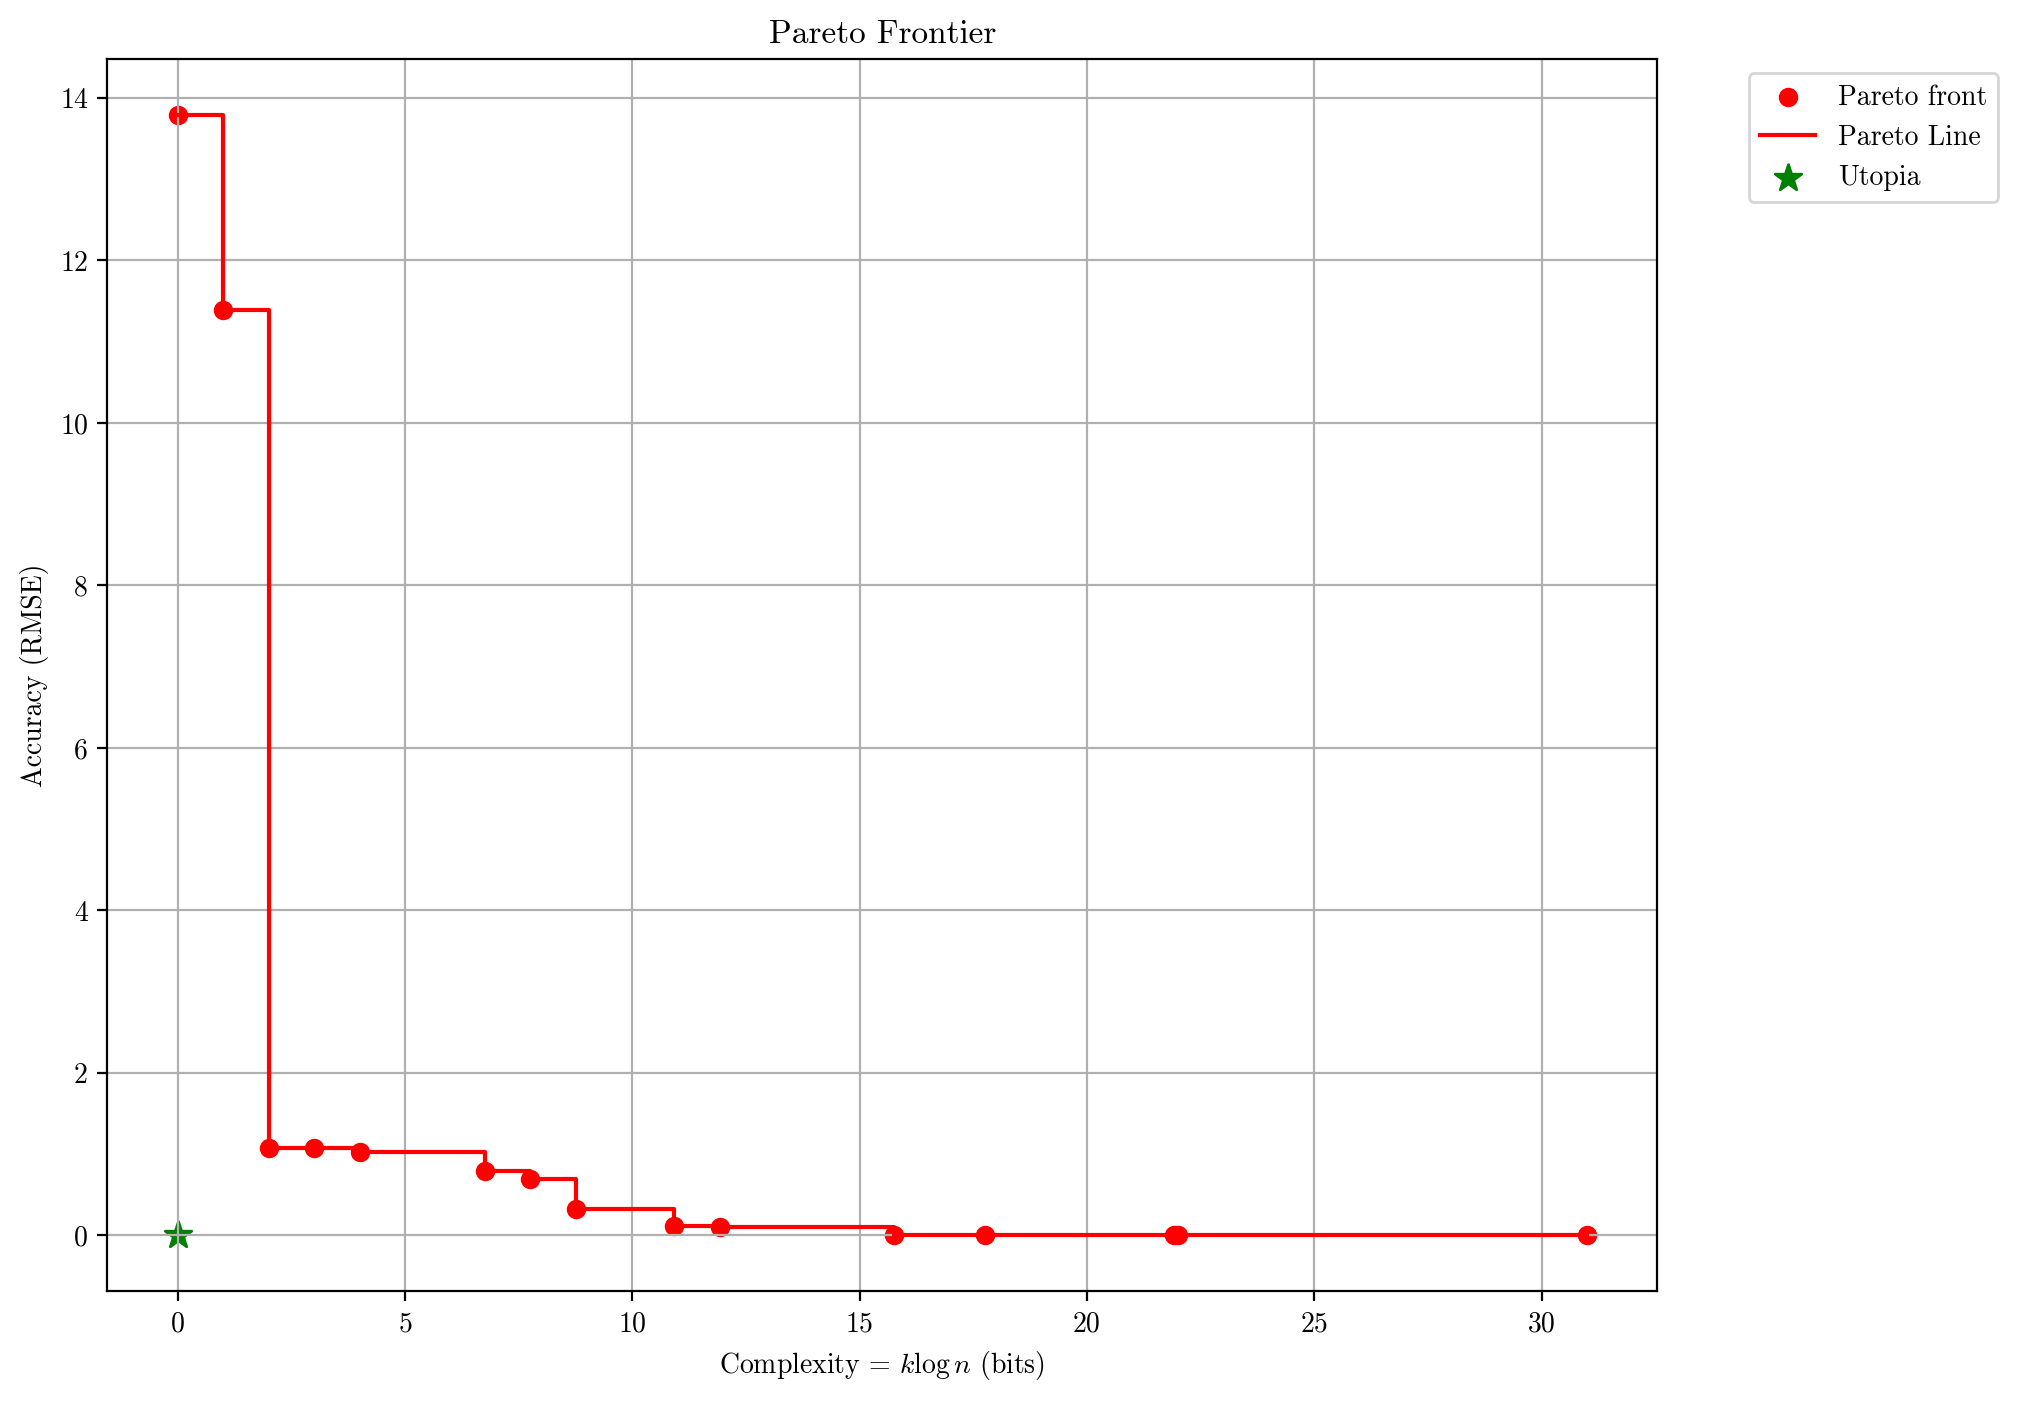

Equation in Latex Format: 



<IPython.core.display.Math object>

In [ ]:
#Generate the data
np.random.seed(42)
X = np.random.uniform(1,5,(10,3))
# use the same function in the example above
Target = X[:,0]**2 + X[:,1]**2 + 2*X[:,0]*X[:,1] + 3*X[:,0] -4
#build the data set
df = pd.DataFrame(X,columns = ['x','y','z'])
df.insert(0,'Target',Target) # target must be the first column
#Run SyMATIC
model = symantic_model(df,operators=['*','pow(2)','+','-'],metrics=[0.04,0.995])
pareto_set = model.fit()
model.plot_pareto_front()

equation = pareto_set['Combined_Equation'].tolist()[-1]

latex_equation = latex(sympify(equation))
print('Equation in Latex Format: \n')
display(Math(latex_equation))


# Dimensional Analysis

## Comparing Non-Dimensional vs. Dimensional Feature Engineering

In this notebook, we compare two approaches to feature engineering: non-dimensional and dimensional, using an example based on the ideal gas law.

## Objective

We aim to demonstrate how a non-dimensional approach, which treats all features as dimensionless and generates combinations using operators (`+`, `-`, `*`, `/`), can lead to a large and often non-physical feature set. In contrast, a dimensional approach respects the physical dimensions of features, resulting in fewer, more meaningful combinations.

## Dataset

We use a synthetic dataset based on the ideal gas law:

$$
P = \frac{nRT}{V}
$$

Where:
- \(P\): Pressure (target)
- \(V\): Volume (m³)
- \(T\): Temperature (K)
- \(n\): Number of moles (mol)
- \(R\): Universal gas constant (J/mol·K)

## Feature Engineering Approaches

### 1. Non-Dimensional (All Dimensions = 1)
- Generates numerous features without considering physical relevance.
- Expected outcome: High feature count, many non-physical combinations.

### 2. Dimensional (Respecting Physical Dimensions)
- Generates features that make physical sense based on dimensions.
- Expected outcome: Fewer, more meaningful features.

## Results and Discussion

The comparison will show that the non-dimensional approach creates a bloated, less interpretable feature set, while the dimensional approach yields a more concise and physically relevant set of features.


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Set up toy dataset for the ideal gas law
X = np.random.uniform(1,5,(30, 4))
dimensionality = ['u1', 'u2', 'u3', 'u4',] #each variable has a unique dimension

# Base feature names
base_feature_names = [f'x_{i+1}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=base_feature_names)
# Target
target = (X[:,2] * X[:,3] * X[:,1]) / (X[:,0])  # P = (nRT)/(V)
df.insert(0, 'target', target)

# Define operators including addition and subtraction
operators = ['+', '-', '*', '/']
df.rename({'target': 'P', 'x_1': 'V','x_2':'T','x_3':'n','x_4':'R',}, axis=1, inplace=True)


#Run SyMANTIC with dimensional analysis
model = symantic_model(df,operators=operators,dimensionality=dimensionality,metrics=[0.001,1.0],disp=True)
pareto_set = model.fit()

equation = pareto_set['Combined_Equation'].tolist()[-1]

latex_equation = latex(sympify(equation))
print('Equation in Latex Format: \n')
display(Math(latex_equation))

print('\n\n\n')
print(['**** '*20], '\n',['**** '*20,] )
print('\n\n\n')

#Run SyMANTIC without dimensional analysis
model = symantic_model(df,operators=operators,metrics=[0.001,1.0],disp=True)
pareto_set = model.fit()







********************************************* Dimension to nondimension feature expansion completed.... with feature space size: 0 ************************************************ 

*********************************** Dimensional feature expansion completed.... with feature space size:  0 ************************************************** 

**************************************** Inter dimensional feature expansion completed, with feature space size:  18 *************************************************** 

***************************** Time taken for the initial feature expansion:  0.035343170166015625  seconds.. ****************************************** 

***************************** Size of the feature space formed in the expansion 22 ******************************** 

!!Important:: Given Number of features in SIS screening is greater than the feature space created, changing the SIS features to shape of features created!!

 ********************************* 2 Feature Expansion i

<IPython.core.display.Math object>





['**** **** **** **** **** **** **** **** **** **** **** **** **** **** **** **** **** **** **** **** '] 
 ['**** **** **** **** **** **** **** **** **** **** **** **** **** **** **** **** **** **** **** **** ']






# Additional Examples

### Example: Lorentz Force and Displacement of a Charged Particle in Electromagnetism

In the study of electromagnetism, the motion and displacement of charged particles under the influence of electric and magnetic fields are fundamental concepts. Two key equations describe these phenomena: the **Lorentz Force** equation and the equation for **displacement** under oscillatory forces.



#### The Lorentz Force Equation

The **Lorentz force** equation describes the combined effect of electric and magnetic forces on a charged particle. It is a fundamental expression in electromagnetism and is given by:

$$
\mathbf{F} = q(\mathbf{E} + \mathbf{v} \times \mathbf{B} \times \sin(\theta))
$$

where:
- $( \mathbf{F} $) is the total force acting on the particle.
- $( q $) is the charge of the particle.
- $( \mathbf{E} $) is the electric field vector.
- $( \mathbf{v} $) is the velocity vector of the particle.
- $( \mathbf{B} $) is the magnetic field vector.
- $( \theta $) is the angle between $( \mathbf{v} ) and ( \mathbf{B} $).






!!Important:: Given Number of features in SIS screening is greater than the feature space created, changing the SIS features to shape of features created!!


Intercept: 3.885780586188048e-16


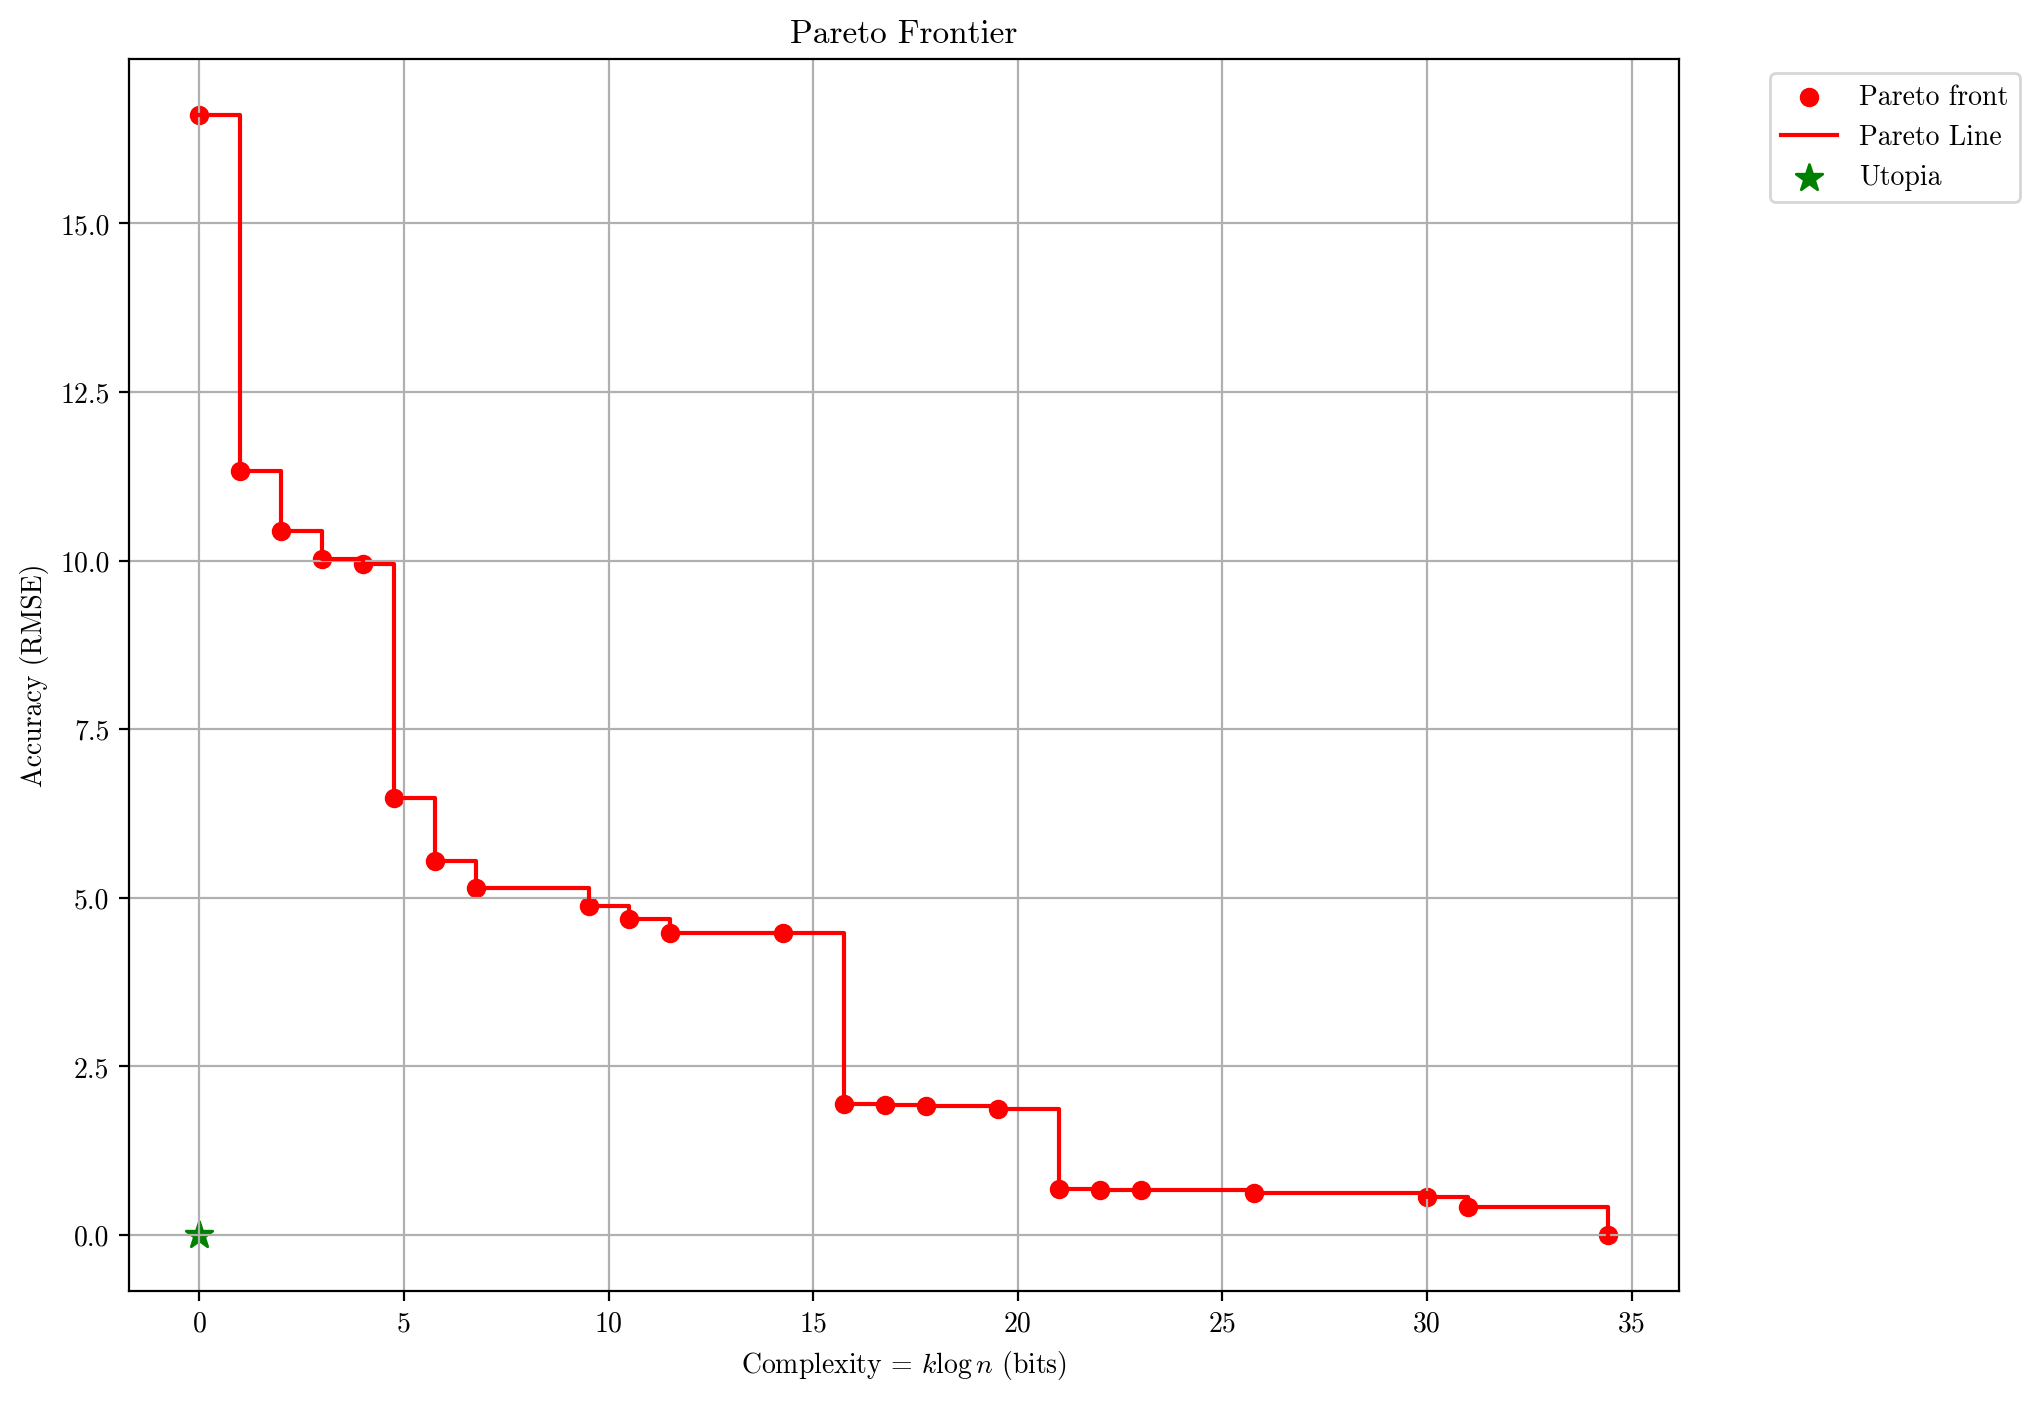

Equation in Latex Format: 



<IPython.core.display.Math object>

In [ ]:
# import and clean up data
df =pd.read_csv('./LorentzForce.dat',sep='\t')
df.drop(df.columns[[0]],axis=1,inplace=True)
df.rename({'x5': 'Force', 'x0': 'q','x1':'E','x2':'v','x3':'B','x4':'theta'},
          axis=1, inplace=True)

#train SyMATIC Model
model = symantic_model(df,operators=['*','sin','+'],
                                        dimensionality=['u1','u2','u3','u4','u4'],
                                        metrics=[0.001,1.0])
pareto_set = model.fit()
model.plot_pareto_front()
equation = pareto_set['Combined_Equation'].tolist()[-1]

latex_equation = latex(sympify(equation))
print('Equation in Latex Format: \n')
display(Math(latex_equation))

##  Example: Squared Euclidean Distance

## Introduction

In physics, the distance between two points in space is a fundamental concept. One of the most common formulas used to calculate this distance is:

$d^2 = (x_2-x_1)^2 + (x_3-x_4)^2$

This equation is a special case of the more general distance formula in n-dimensional space. Let's explore its significance, applications, and variations in physics.


## Applications in Physics

- **Displacement**: Calculate the displacement of an object in 2D space
- **Trajectory Analysis**: Analyze the path of projectiles

- **Field Strength**: Calculate the strength of electric or magnetic fields at a point
- **Potential Difference**: Determine voltage differences in an electric field

- **Probability Densities**: Used in calculating probability distributions of particles
- **Uncertainty Principle**: Relates to measurements of position in phase space



## Example: Relativistic Mass of an Object


In the context of special relativity, the concept of mass becomes dependent on the velocity of the object relative to the observer. This leads to the idea of **relativistic mass**, which increases with velocity as an object approaches the speed of light. The equation that describes the relativistic mass \( m \) is given by:

#### (B) Relativistic Mass Equation

$$
m^2 = \frac{m_0^2}{1 - \frac{v^2}{c^2}}
$$

where:
- $( m $) is the relativistic mass of the object when it is moving at velocity ( v ).
- $( m_0 $) is the rest mass of the object, which is the mass of the object when it is at rest (i.e., ( v = 0)).
- $( v $) is the velocity of the object relative to the observer.
- $( c $) is the speed of light in a vacuum, approximately $( 3 \times 10^8 $) meters per second.



!!Important:: Given Number of features in SIS screening is greater than the feature space created, changing the SIS features to shape of features created!!


Intercept: 1.4481301491287013e-08


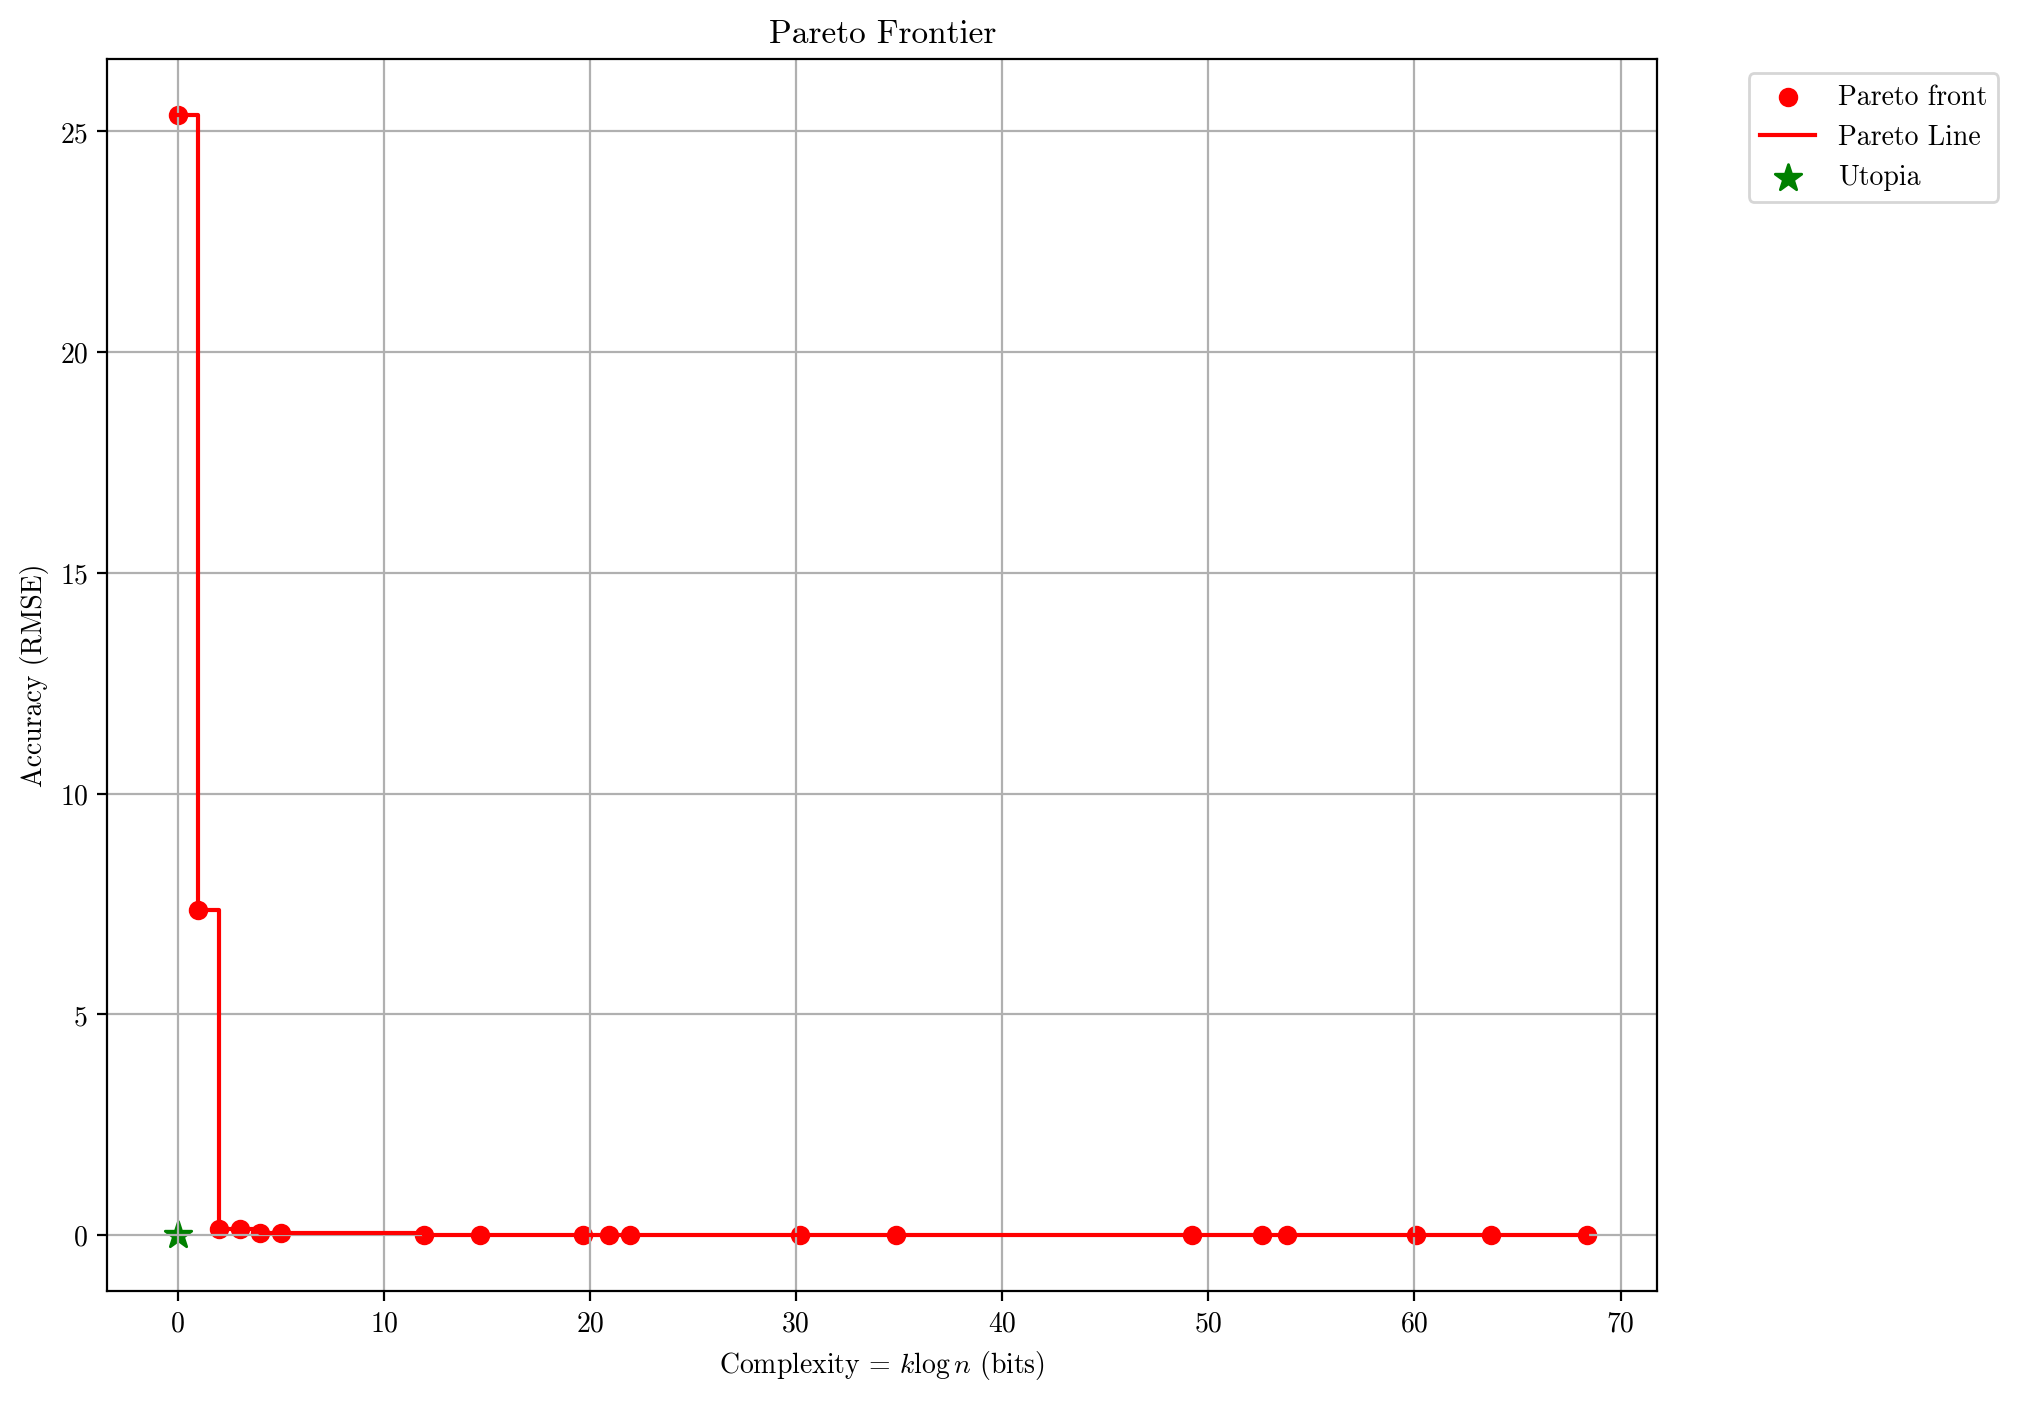

Equation in Latex Format: 



<IPython.core.display.Math object>

In [ ]:
# select which equation to model
x=False
if x:
  df = pd.read_csv('./distance.dat',sep='\t')
  dimensionality=['u1','u2','u2']
  operators=['+','-','pow(1/2)','pow(2)']
else:
  df = pd.read_csv('./relative_mass.dat',sep='\t')
  dimensionality=['u1','u2','u2']
  operators=['/','*','pow(2)','-']

#Clean up data
df.drop(df.columns[[0]],axis=1,inplace=True)
df.rename({'x0': 'm0','x1':'v'}, axis=1, inplace=True) #comment out for distance

#Run SyMANTIC

model = symantic_model(df,operators=operators,
                                        dimensionality=dimensionality,
                                        metrics=[0.001,1.0])
pareto_set = model.fit()


model.plot_pareto_front()

equation = pareto_set['Combined_Equation'].tolist()[-3]

latex_equation = latex(sympify(equation))
print('Equation in Latex Format: \n')
display(Math(latex_equation))



##  Example: System Identification: CSTR


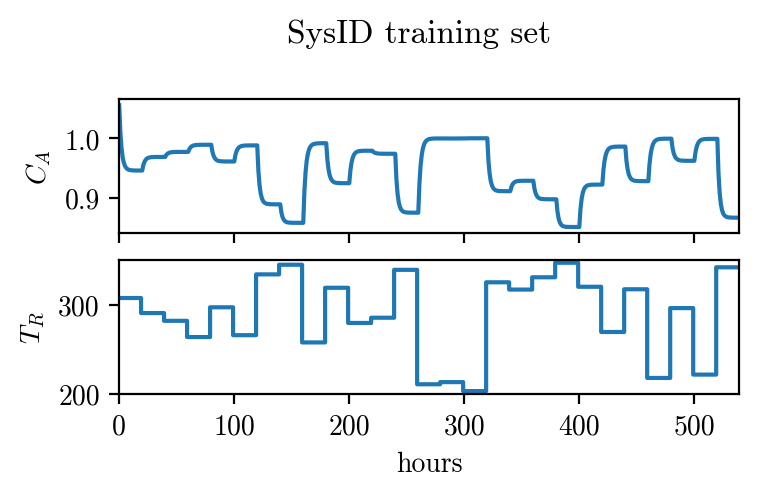

In [ ]:
### Build CSTR simulator and data
# Define the CSTR model with a cooling jacket

np.random.seed(0)

def cstr_model(t, y, u):
    CA = y  # State
    TR = u  # Control variable
    # Parameters
    CA0 = 1
    k0 = .5e3
    E_R = 3000
    V = 1.0
    F = .5

    # ODE
    dCA_dt = (F/V) * (CA0 - CA) + -k0 * CA* np.exp(-E_R / (TR))

    return dCA_dt

# Simulate the CSTR model
def simulate_cstr(t_end, dt, initial_conditions, control_inputs):
    t = np.arange(0, t_end, dt)
    y = np.zeros((len(t), 1))
    y[0] = initial_conditions

    for i in range(1, len(t)):
        t_span = [t[i-1], t[i]]
        u = control_inputs[i-1]
        sol = integrate.solve_ivp(cstr_model, t_span, y[i-1], args=(u,), method='RK45')
        y[i] = sol.y[:, -1]

    return t, y

# Generate dataset
def generate_dataset(hold=20):
    t_end = 540.0  # total simulation time
    dt = 1      # time step
    initial_conditions = np.random.uniform(1, 1.1, 1)  # Initial CA
    t = np.arange(0, t_end, dt)

    # Random control inputs
    TR = np.vstack([np.random.uniform(200, 350, int(len(t)/hold))]*hold).T.flatten()
    control_inputs = TR

    # Simulate the system
    _, states = simulate_cstr(t_end, dt, initial_conditions, control_inputs)

    # Combine inputs and states to form dataset
    data = np.column_stack((control_inputs, states, np.ones_like(states)*.5))
    return data, t


# Generate dataset
data, t = generate_dataset()
def plot_data(data,t):
  plt.figure()
  plt.suptitle('SysID training set')
  plt.subplot(4,1,1)
  plt.plot(t,data[:,1])
  plt.ylabel(f'$C_A$')
  plt.tick_params('x', labelbottom=False)
  plt.xlim(0, t.max())


  plt.subplot(4,1,2)
  plt.step(t,data[:,0])
  plt.ylabel(f'$T_R$')
  plt.xlim(0, t.max())
  plt.ylim(200,350)
  plt.xlabel('hours')

  #plt.tight_layout()

plot_data(data,t)


In [ ]:
x,y = data[:300,0].reshape(-1, 1), data[:300, 1]
x_test,y_test = data[300:,0].reshape(-1, 1), data[300:, 1]


### Build SR model
lags = 3
x,y = [], []
for i in range(lags, 200):
  x.append([data[i,0]] +list(data[i-lags:i,1]))
  y.append(data[i,1])
x = np.array(x)
y = np.array(y)

np.random.seed(42)
x = x+np.random.normal(0,0.00,x.shape) #Only add noise to training data
y = y+np.random.normal(0,0.00,y.shape)

x_test,y_test = [], []
for i in range(200,data.shape[0] ):
  x_test.append([data[i,0]] +list(data[i-lags:i,1]))
  y_test.append(data[i,1])
x_test = np.array(x_test)
y_test = np.array(y_test)


df = pd.DataFrame({'CA_l0':y,'T_R':x[:,0],'CA_l1':x[:,1],
                   'CA_l2':x[:,2],'CA_l3':x[:,3]})

df_test = pd.DataFrame({'CA_l0':y_test,'T_R':x_test[:,0],'CA_l1':x_test[:,1],
                        'CA_l2':x_test[:,2],'CA_l3':x_test[:,3]})


operators = ['*','exp','/']

#define termination criteria [RMSE, R^2]
metrics=[.001,.99]

df1 = df.sample(n=20,random_state=42)
print(df1)

index = df1.index

df1.reset_index(drop=True,inplace=True)

model = symantic_model(df1,operators=operators, metrics=metrics,disp=True,sis_features=10)
pareto_set = model.fit()

equation = pareto_set['Combined_Equation'].tolist()[-1]

latex_equation = latex(sympify(equation))
print('Equation in Latex Format: \n')
display(Math(latex_equation))


        CA_l0         T_R     CA_l1     CA_l2     CA_l3
140  0.863447  344.549414  0.889002  0.875338  0.867708
113  0.987692  265.638082  0.987663  0.987678  0.987687
16   0.945601  307.278405  0.945619  0.945610  0.945604
75   0.988741  263.548220  0.988736  0.988738  0.988740
155  0.858061  344.549414  0.858065  0.858063  0.858061
186  0.924919  318.758756  0.927012  0.925923  0.925288
69   0.988714  263.548220  0.988616  0.988666  0.988696
55   0.976811  281.732477  0.976808  0.976809  0.976810
18   0.954792  290.414506  0.945604  0.945601  0.945599
170  0.991165  257.516228  0.990494  0.990835  0.991041
175  0.991339  257.516228  0.991285  0.991312  0.991329
15   0.945604  307.278405  0.945635  0.945619  0.945610
162  0.980649  257.516228  0.942744  0.961999  0.973627
60   0.986125  263.548220  0.976811  0.981547  0.984403
115  0.987697  265.638082  0.987687  0.987692  0.987695
114  0.987695  265.638082  0.987678  0.987687  0.987692
146  0.858223  344.549414  0.858998  0.858584  0

<IPython.core.display.Math object>

(200.0, 350.0)

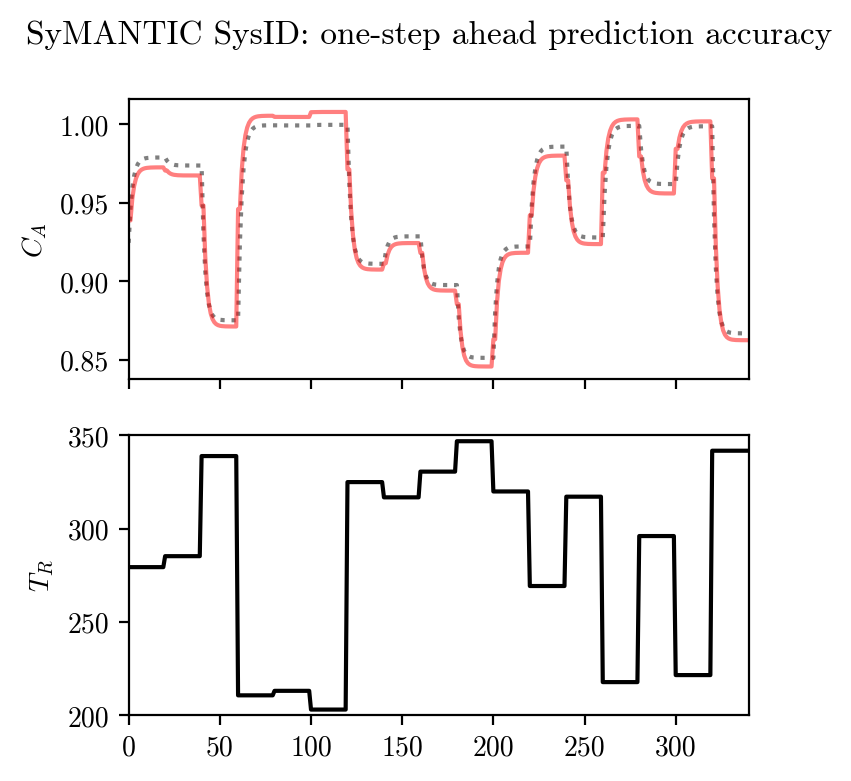

In [ ]:

CA_l1,CA_l2,CA_l3,T_R = df_test['CA_l1'],df_test['CA_l2'],df_test['CA_l3'],df_test['T_R']
def exp(x):
  return np.exp(x)

yp = eval(pareto_set.Combined_Equation.tolist()[-1])

#yp = -0.00181*T_R + 1.02812*CA_l3  -119.24222*(CA_l3/T_R) + 0.89875 # 15 samples
#yp = -0.74710*CA_l2 + 1.74712*CA_l3 #  5 samples
#yp =  1.1091 -67.03835*(CA_l2/T_R)+0.166762*(exp(CA_l3))-0.001189*(T_R/CA_l3) #  10 samples

plt.figure()
plt.suptitle('SyMANTIC SysID: one-step ahead prediction accuracy')
plt.subplot(2,1,1)
plt.plot(np.arange(len(y_test)), y_test, 'k:',alpha=.5)
plt.plot(np.arange(len(yp)), yp, 'r',alpha=.5)
plt.ylabel(f'$C_A$')
plt.tick_params('x', labelbottom=False)
plt.xlim(0,len(y_test))

plt.subplot(2,1,2)
plt.plot(np.arange(len(y_test)), x_test, 'k')
plt.ylabel(f'$T_R$')
plt.xlim(0, len(y_test))
plt.ylim(200,350)

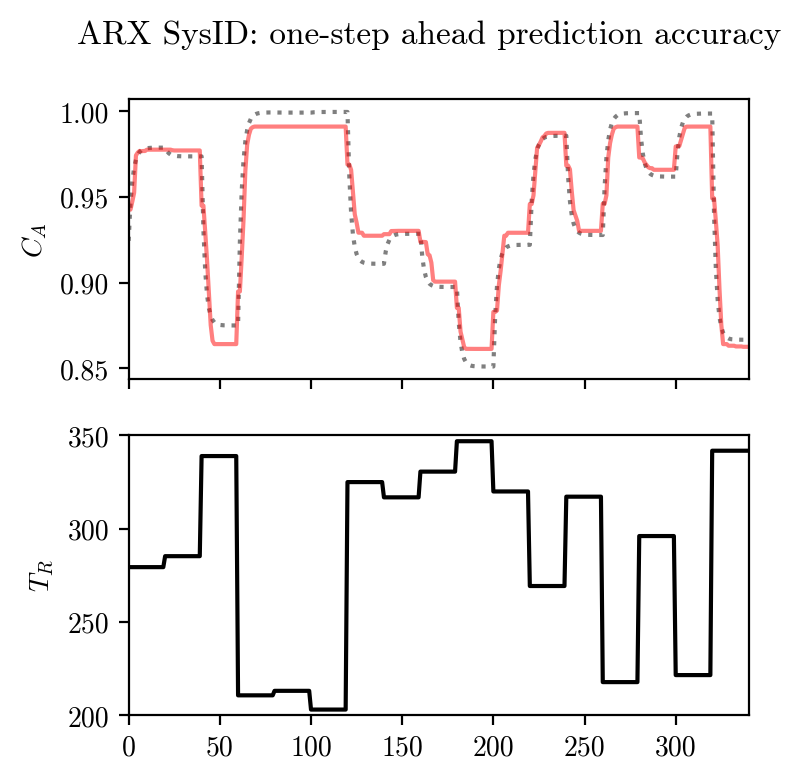

In [ ]:

x1,y1 = x[index],y[index].reshape(-1,1)


#model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
#model = make_pipeline(StandardScaler(), Lasso(alpha=0.01))
model = make_pipeline(StandardScaler(), RandomForestRegressor())

# Train the model
model.fit(x1,y1)

# Generate 1-step ahead predictions
ypred1 = model.predict(x_test)


plt.figure()
plt.suptitle('ARX SysID: one-step ahead prediction accuracy')
plt.subplot(2,1,1)
plt.plot(np.arange(len(y_test)), y_test, 'k:',alpha=.5)
plt.plot(np.arange(len(ypred1)), ypred1, 'r' ,alpha=.5)
plt.ylabel(f'$C_A$')
plt.tick_params('x', labelbottom=False)
plt.xlim(0,len(y_test))

plt.subplot(2,1,2)
plt.plot(np.arange(len(y_test)), x_test, 'k')
plt.ylabel(f'$T_R$')
plt.xlim(0, len(y_test))
plt.ylim(200,350)



narx_loss = y_test.flatten()-ypred1.flatten()

try:
  basemodel = model[-1]  # Extract the Ridge model from the pipeline
  print("Model Coefficients:", basemodel.coef_)
  print("Model Intercept:", basemodel.intercept_)
except:
  pass

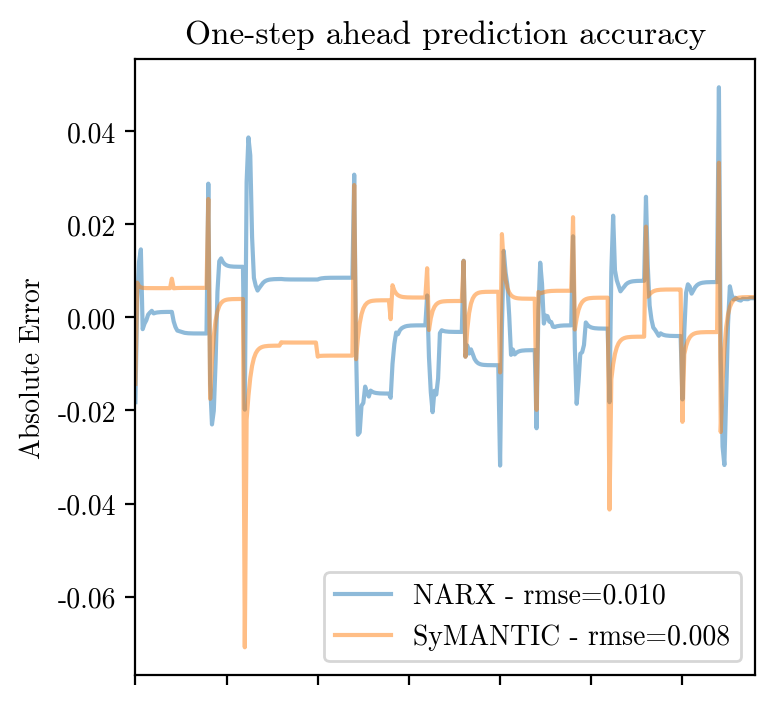

In [ ]:


sr_loss = df_test['CA_l0']-yp

narx_rmse = np.sqrt(np.mean(narx_loss**2))
sr_rmse =  np.sqrt(np.mean(sr_loss**2))



plt.figure()
plt.title('One-step ahead prediction accuracy')

plt.plot(narx_loss, label=f'NARX - rmse={narx_rmse:.3f}'  , alpha=.5)
plt.plot(sr_loss, label = f'SyMANTIC - rmse={sr_rmse:.3f}', alpha=.5)

plt.ylabel('Absolute Error')
plt.tick_params('x', labelbottom=False)
plt.xlim(0,len(y_test))
plt.legend()



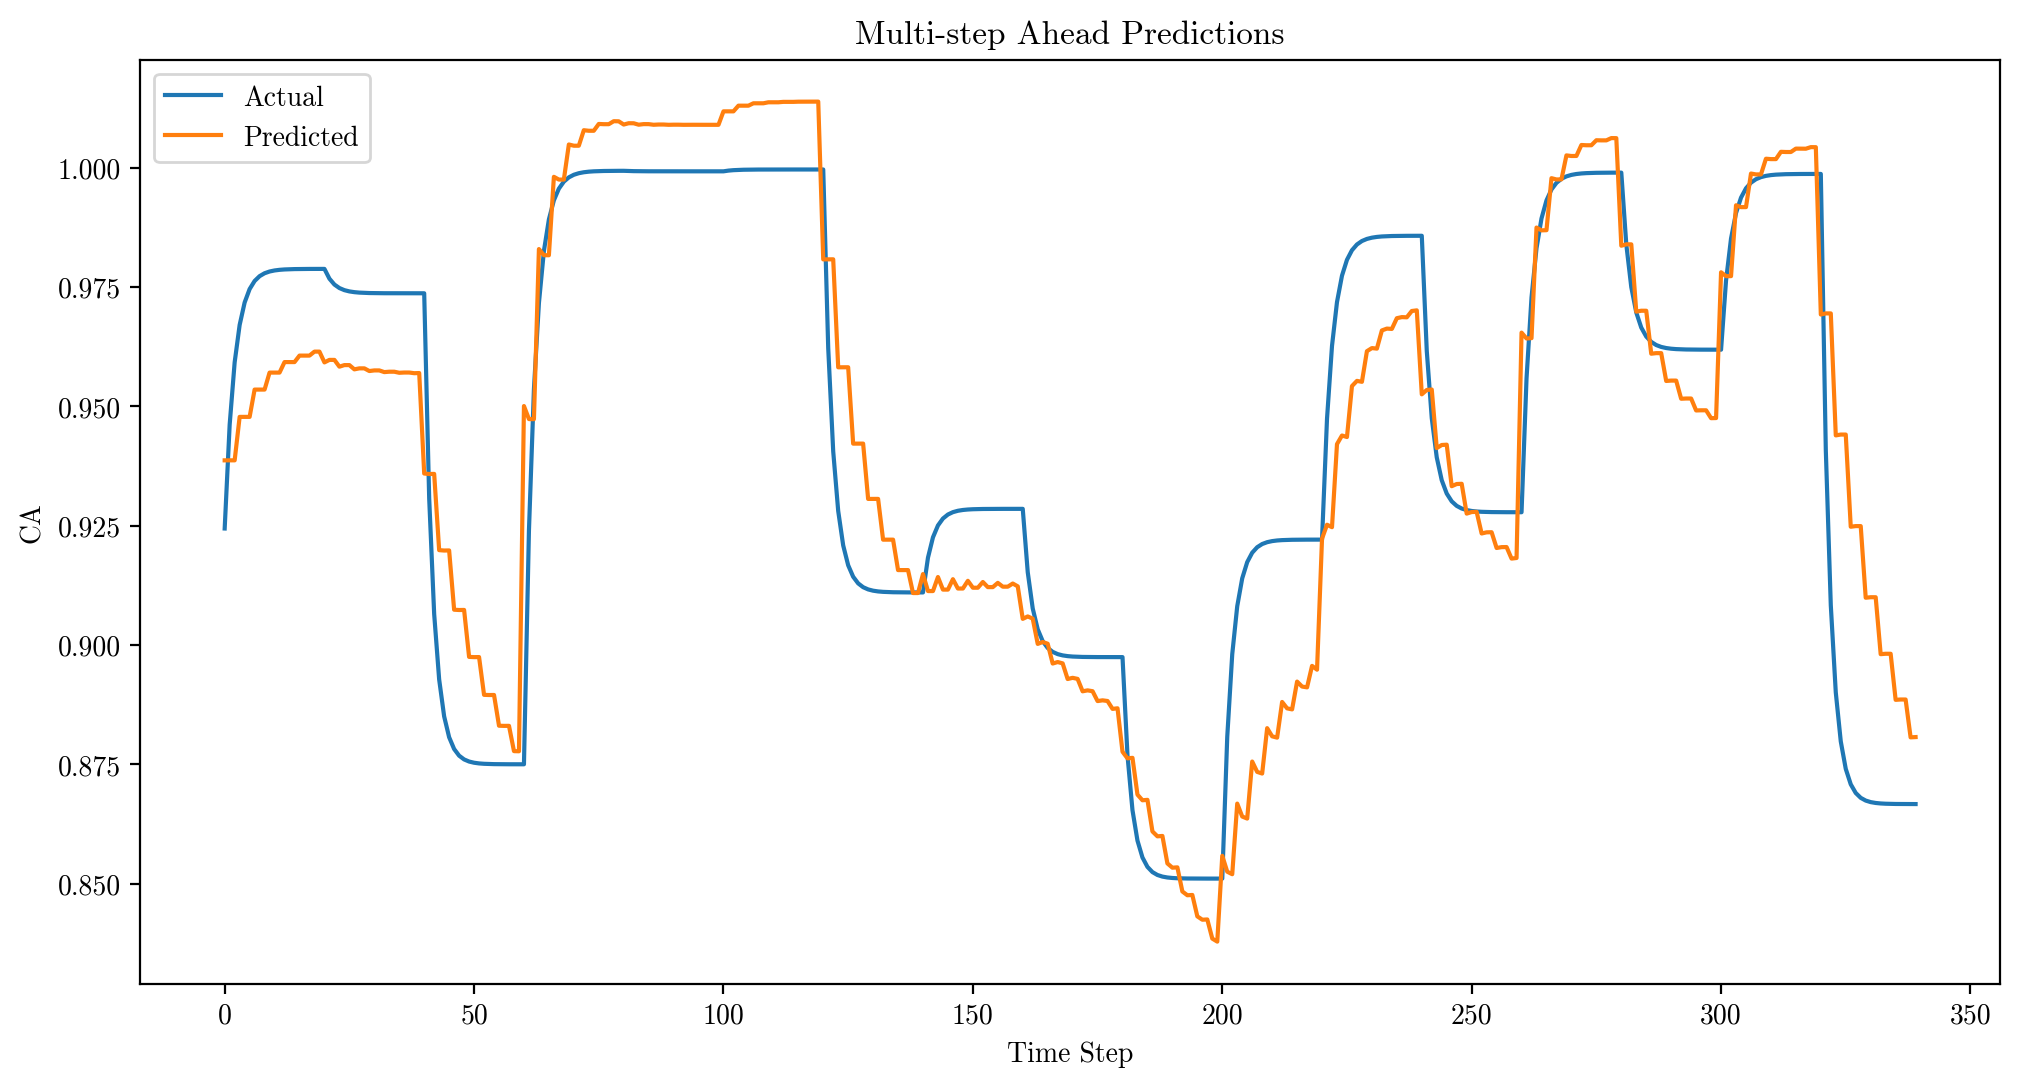

0.020258513450306326

In [ ]:
import numpy as np
from sympy import sympify, lambdify

def symbolic_model(T_R, CA_l1, CA_l2, CA_l3):
    # Replace this with your actual equation
    equation = pareto_set.Combined_Equation.tolist()[-1]
    expr = sympify(equation)
    f = lambdify(('T_R', 'CA_l1', 'CA_l2', 'CA_l3'), expr)
    return f(T_R, CA_l1, CA_l2, CA_l3)


def multi_step_prediction(initial_conditions, T_R_future, n_steps):
    predictions = []
    CA_l1, CA_l2, CA_l3 = initial_conditions

    for i in range(n_steps):
        T_R = T_R_future[i]
        CA_pred = symbolic_model(T_R, CA_l1, CA_l2, CA_l3)
        predictions.append(CA_pred)

        # Update lags for next iteration
        CA_l3, CA_l2, CA_l1 = CA_l2, CA_l1, CA_pred

    return np.array(predictions)

# Example usage
initial_conditions = [df_test['CA_l1'].iloc[0], df_test['CA_l2'].iloc[0], df_test['CA_l3'].iloc[0]]
T_R_future = df_test['T_R'].values
n_steps = len(T_R_future)

predictions = multi_step_prediction(initial_conditions, T_R_future, n_steps)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_test['CA_l0'].values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('CA')
plt.title('Multi-step Ahead Predictions')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, r2_score

# Calculate metrics
rmse = np.sqrt(mean_squared_error(df_test['CA_l0'], predictions))

rmse



## Example: Differential Equations and Solutions: The Lorenz System

The **Lorenz system** is a system of three coupled, nonlinear differential equations originally developed by Edward Lorenz in 1963. This system was originally intended to model atmospheric convection, but it is widely known for its chaotic solutions, which have become one of the most famous examples of deterministic chaos in the study of dynamical systems.

#### The Lorenz Equations

The Lorenz system is defined by the following set of ordinary differential equations (ODEs):

$$
\frac{dx}{dt} = \sigma (y - x)
$$

$$
\frac{dy}{dt} = x (\rho - z) - y
$$

$$
\frac{dz}{dt} = x y - \beta z
$$

where:

- \( x(t) \), \( y(t) \), and \( z(t) \) are the system states as functions of time \( t \).
- $( \sigma $) is the Prandtl number, a dimensionless number that governs the rate of convection.
- $( \rho $) is the Rayleigh number, which is proportional to the temperature difference driving the convection.
- $( \beta $) is a geometrical factor, typically related to the physical dimensions of the system.

#### Standard Parameter Values

In the original study by Lorenz, the following parameter values were used, which are commonly adopted in studies of the Lorenz system:

$$
\sigma = 10, \quad \rho = 28, \quad \beta = \frac{8}{3}
$$

With these parameters, the Lorenz system exhibits chaotic behavior, meaning that tiny differences in initial conditions can lead to vastly different outcomes, a hallmark of chaotic systems.

#### Numerical Solutions and Chaotic Behavior

The Lorenz system is typically solved numerically because the equations are nonlinear and do not have a closed-form analytical solution. The solutions to these equations can be plotted in three-dimensional space, where the resulting trajectories often form a butterfly-shaped pattern known as the **Lorenz attractor**.



In [ ]:
np.random.seed(42)

def lorenz_system(t, state, sigma, rho, beta):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

def calculate_lorenz_attractor_with_noise(sigma=10, rho=28, beta=8/3, initial_state=[-8, -8, 27],
                                          t_span=(0, 100), num_points=10000, noise_strength=0.1):
    def lorenz_wrapper(t, state):
        return lorenz_system(t, state, sigma, rho, beta)

    # Solve the Lorenz system
    solution = solve_ivp(lorenz_wrapper, t_span, initial_state, t_eval=np.linspace(t_span[0], t_span[1], num_points))

    t = solution.t
    x, y, z = solution.y

    noise_x = np.random.normal(0, noise_strength, num_points)
    noise_y = np.random.normal(0, noise_strength, num_points)
    noise_z = np.random.normal(0, noise_strength, num_points)

    x_noisy = x + noise_x
    y_noisy = y + noise_y
    z_noisy = z + noise_z


    derivatives = np.array([lorenz_system(t_i, [x_n, y_n, z_n], sigma, rho, beta)
                            for t_i, x_n, y_n, z_n in zip(t, x_noisy, y_noisy, z_noisy)])
    dx, dy, dz = derivatives.T

    df = pd.DataFrame({
        'DX': dx,
        'DY': dy,
        'DZ': dz,
        'x': x,
        'y': y,
        'z': z
    })

    return df


lorenz_df = calculate_lorenz_attractor_with_noise(noise_strength=0.00)


df = lorenz_df.sample(n=5) # number of datapoints

df.reset_index(drop=True,inplace=True)




print('*********************************** Starting SyMANTIC ******************************** \n')
operators = ['*']
_,_,_,equations = symantic_model(df,operators=operators,multi_task=[[0,1,2],[[3,4,5],[3,4,5],[3,4,5]]],metrics=[0.05,0.99],disp=False).fit()



print('*********************** Final Set of Equations ***************************')
d = ["(x') = ","(y') = ","(z') = "]
for i in range(len(equations)):
    #equations[i] = round_coefficients(equations[i])
    print(d[i],equations[i])


*********************************** Starting SyMANTIC ******************************** 

*********************** Final Set of Equations ***************************
(x') =  -10.00000000000000355271*x   + 10.00000000000000177636*y  
(y') =  -1.00000000000000155431*(x*z)   + 28.00000000000006394885*x  -1.00000000000002442491*y  
(z') =  -2.66666666666666829499*z   + 1.00000000000000022204*(x*y)  


(0.0, 15.0)

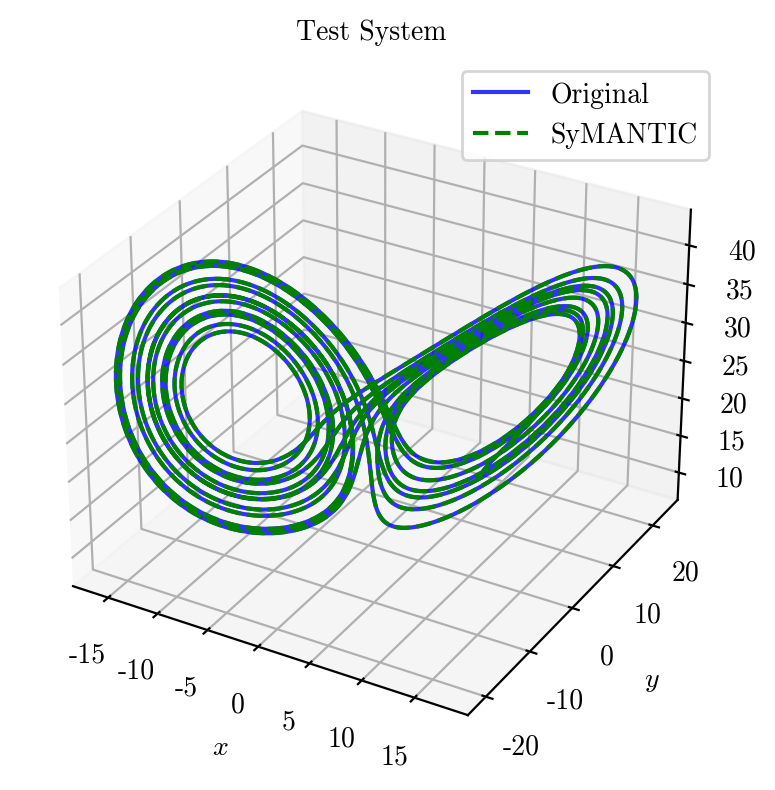

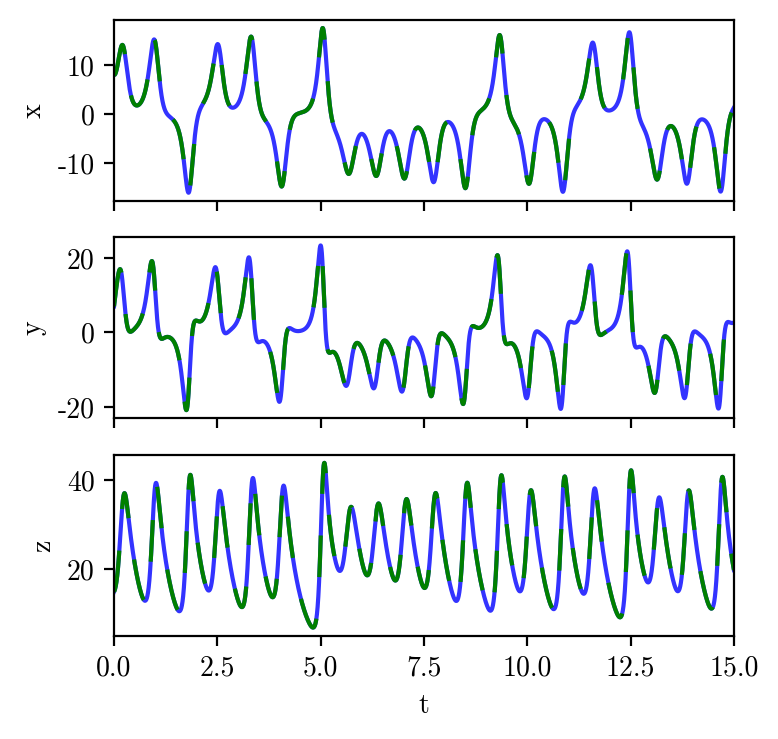

In [ ]:

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

def lorenz_system1(t, state,sigma=10, rho=28, beta=8/3):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]


t_test = np.arange(0, 15, 0.001)
x0_test = np.array([8, 7, 15])
t_test_span = (t_test[0], t_test[-1])
x_test = solve_ivp(
    lorenz_system1, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T



def lorenz_2(t,state):
    x = state[0]
    y=state[1]
    z=state[2]
    return [eval(equations[0]),eval(equations[1]),eval(equations[2])]


x_test2= solve_ivp(
    lorenz_2, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T



fs = 10

fig = plt.figure()
ax1 = plt.axes(projection="3d")
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], color='blue', label='Original', alpha=0.8, lw=1.5, linestyle='-')
ax1.plot(x_test2[:, 0], x_test2[:, 1], x_test2[:, 2], color='green', label='SyMANTIC', alpha=1.0, lw=1.5, linestyle='--')

ax1.set_xlabel("$x$", fontsize=fs, weight='bold')
ax1.set_ylabel("$y$", fontsize=fs, weight='bold')
ax1.set_zlabel("$z$", fontsize=fs, weight='bold')

ax1.tick_params(axis='x', labelsize=fs)
ax1.tick_params(axis='y', labelsize=fs)
ax1.tick_params(axis='z', labelsize=fs)
ax1.set_title("Test System", fontsize=fs, weight='bold')
plt.legend()
plt.tight_layout()



fig = plt.figure()
plt.subplot(3,1,1)
plt.plot(t_test[:], x_test[:,0], label='Original', alpha=0.8, c='blue', linewidth=1.5,linestyle='-')
line2, = plt.plot(t_test[:], x_test2[:,0], label='SyMANTIC', alpha=1.0, c='green', linewidth=1.5,linestyle='--')
line2.set_dashes([10, 10])
plt.tick_params('x', labelbottom=False)
plt.ylabel('x',weight='bold',fontsize=fs)
plt.xlim(0,15)
######
plt.subplot(3,1,2)
plt.plot(t_test[:], x_test[:,1], label='Original', alpha=0.8, c='blue', linewidth=1.5,linestyle='-')
line2, = plt.plot(t_test[:], x_test2[:,1], label='SyMANTIC', alpha=1.0, c='green', linewidth=1.5,linestyle='--')
line2.set_dashes([10, 10])
plt.tick_params('x', labelbottom=False)
plt.ylabel('y',weight='bold',fontsize=fs)
plt.xlim(0,15)
######
plt.subplot(3,1,3)
plt.plot(t_test[:], x_test[:,2], label='Original', alpha=0.8, c='blue', linewidth=1.5,linestyle='-')
line2, = plt.plot(t_test[:], x_test2[:,2], label='SyMANTIC', alpha=1.0, c='green', linewidth=1.5,linestyle='--')
line2.set_dashes([10, 10])
plt.xlabel('t',weight='bold',fontsize=fs)
plt.ylabel('z',weight='bold',fontsize=fs)
plt.xlim(0,15)


